In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline


# Blind source separation using NMF

Toy example using two sinusoidal signals


In [3]:
print(__doc__)

import os as os
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as sp
from scipy import io
from scipy.signal import stft, istft, spectrogram, chirp, butter, lfilter, freqz
from sklearn.decomposition import NMF
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from numpy import linalg


Automatically created module for IPython interactive environment


In [4]:
plt.rcParams['figure.figsize'] = (12.0, 9.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'
plt.rc('text', usetex=True)
plt.rc('font', family='times')
plt.rcParams.update({'font.size': 26})

In [5]:
figPath = './figs-01-31/'
fs = int(10e6)
f1 = 1e6
secondsOfData = 0.01
numberOfSamples = int(secondsOfData*fs)
nfft = 256
nperseg = 256
beta_loss = 'kullback-leibler'
save_fig = False
exp_name = '1sin_noise'

In [6]:
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a


def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

In [7]:
def db2pow(y):
    return 10.**(y/10.)

In [8]:
def pow_eval(y):
    return (np.linalg.norm(y)**2)/len(y)

In [9]:
def plotSpectrogram(f, t, Sxx, vmin=None, vmax=None, save_fig=False, fig_path=None, figName=None):
    specdB = 10*np.log10(np.abs(Sxx))    
    cmap = plt.get_cmap('jet')
    
    if vmin==None and vmax==None:
        vmin = np.min(specdB)
        vmax = np.max(specdB)       
        
    plt.pcolormesh(t*1e3, f/1e6, specdB, vmin=vmin, vmax=vmax, cmap=cmap)
    plt.ylabel('Frequency [MHz]')
    plt.xlabel('Time [ms]')
    plt.colorbar().ax.set_ylabel('[dB]')
    plt.tight_layout()
    if save_fig:
        if not os.path.exists(fig_path):
            os.makedirs(fig_path)
        figName = ''.join([figName, '.eps'])
        plt.savefig(os.path.join(fig_path,figName), dpi=100, format='eps')
    plt.show()

In [10]:
def saveFig(fig, fig_path, fig_name, save_fig=False):
    if save_fig:
        if not os.path.exists(fig_path):
            os.makedirs(fig_path)
        fig_name = ''.join([fig_name, '.eps'])
        fig.savefig(os.path.join(fig_path, fig_name), dpi=100, format='eps')

In [11]:
def mean_window(y, window_length, hop_size=1):
    aux = (y.shape[0] - window_length)//hop_size
    if aux is not int(aux):
         raise ValueError('Window size and hop size are incompatible')
            
    number_of_windows = aux + 1
    window = []
    for i in range(number_of_windows):
        window.append(np.mean(y[i:i+window_length:hop_size]))
    return np.asarray(window)

# Generate and mix signals

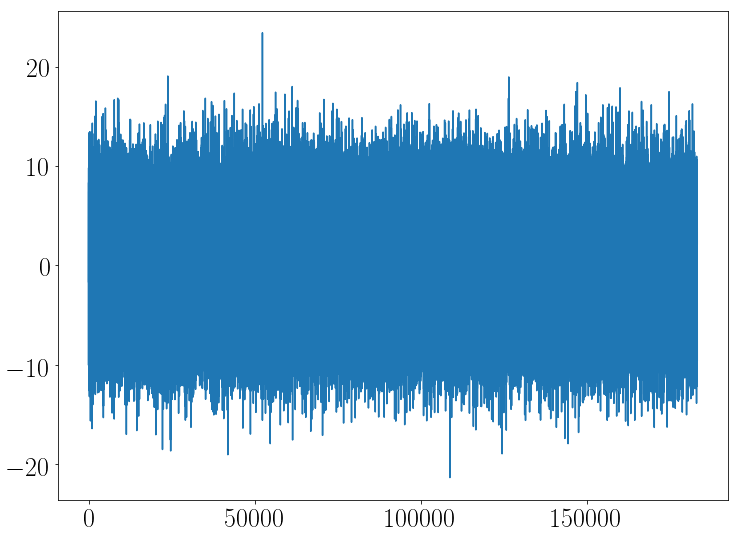

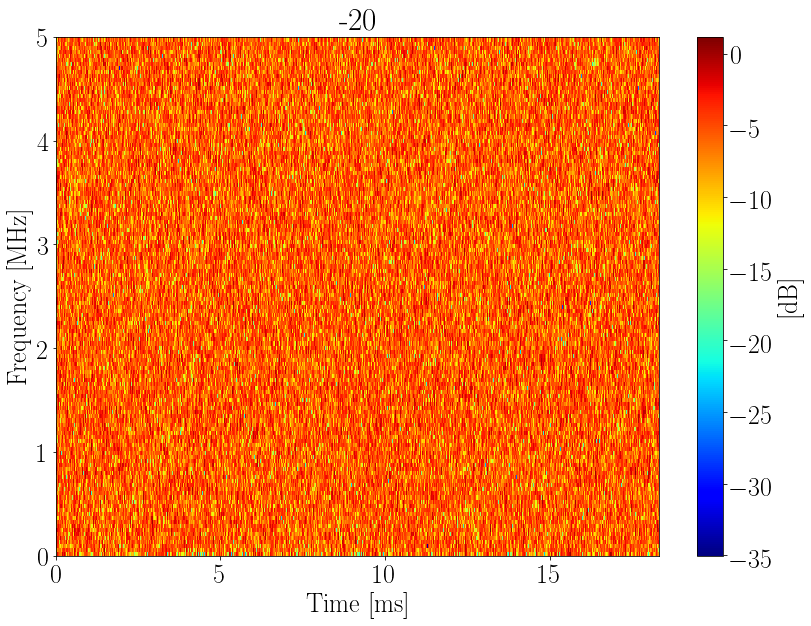

Epoch 10 reached after 0.021 seconds, error: 125.154936
Epoch 20 reached after 0.039 seconds, error: 125.154936


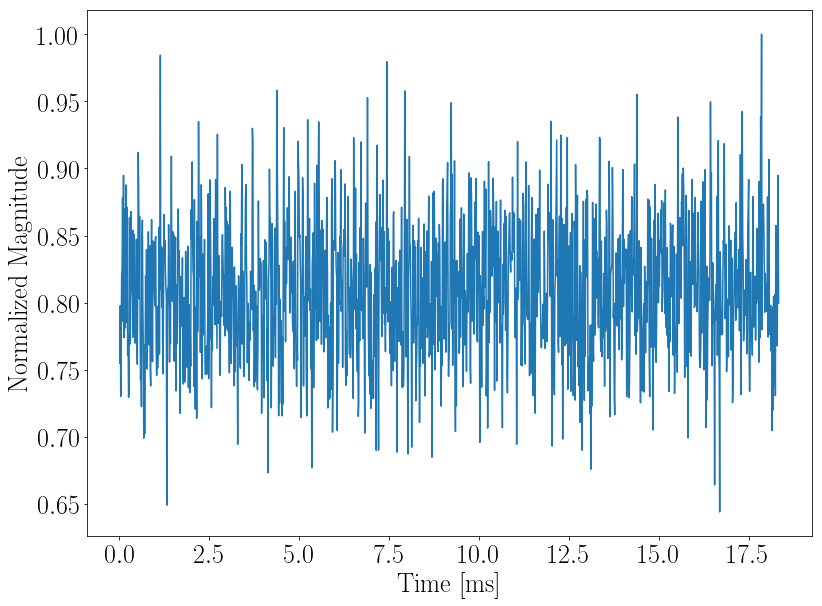

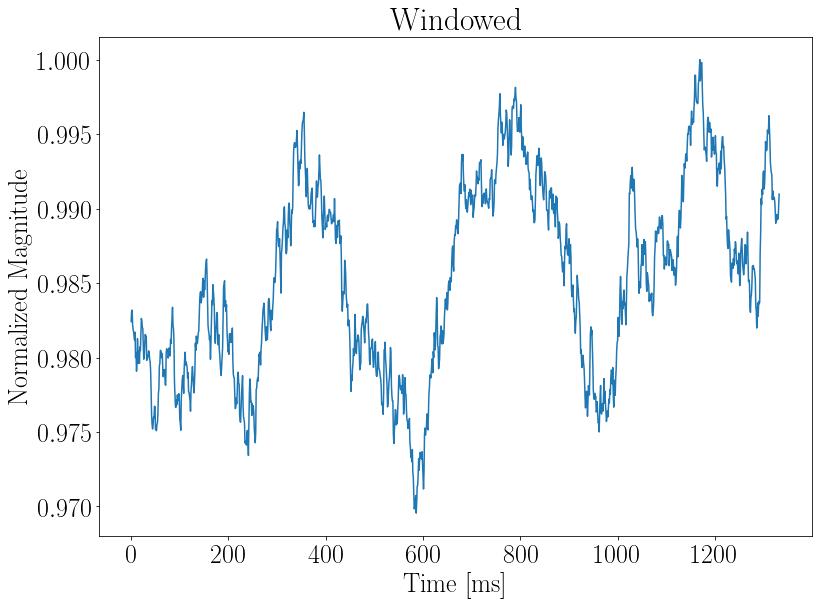

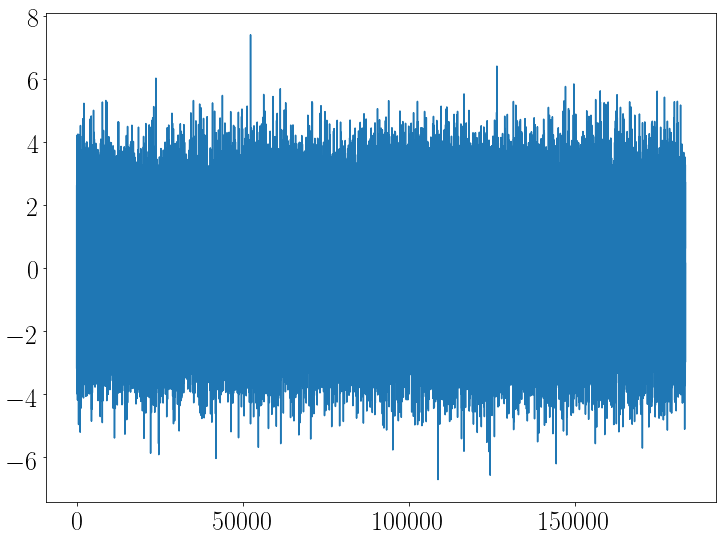

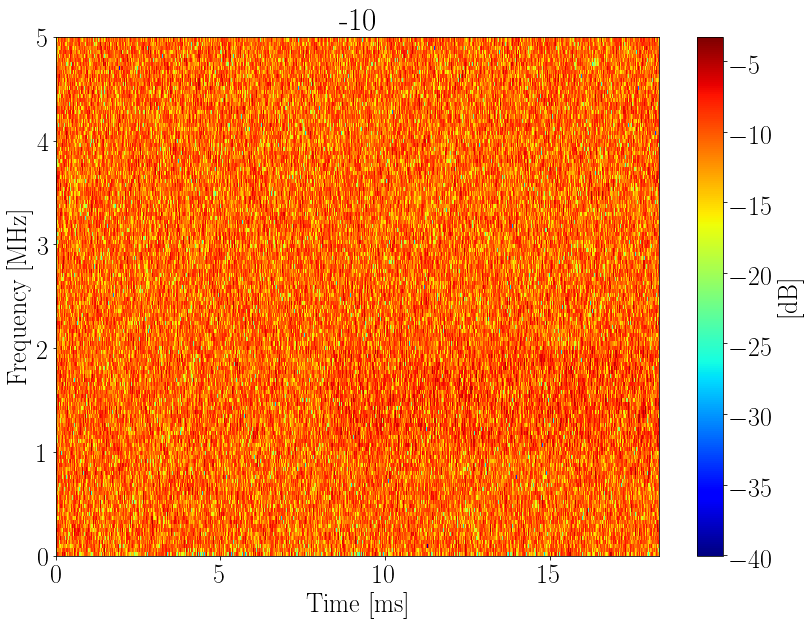

Epoch 10 reached after 0.023 seconds, error: 71.322605
Epoch 20 reached after 0.040 seconds, error: 71.322605


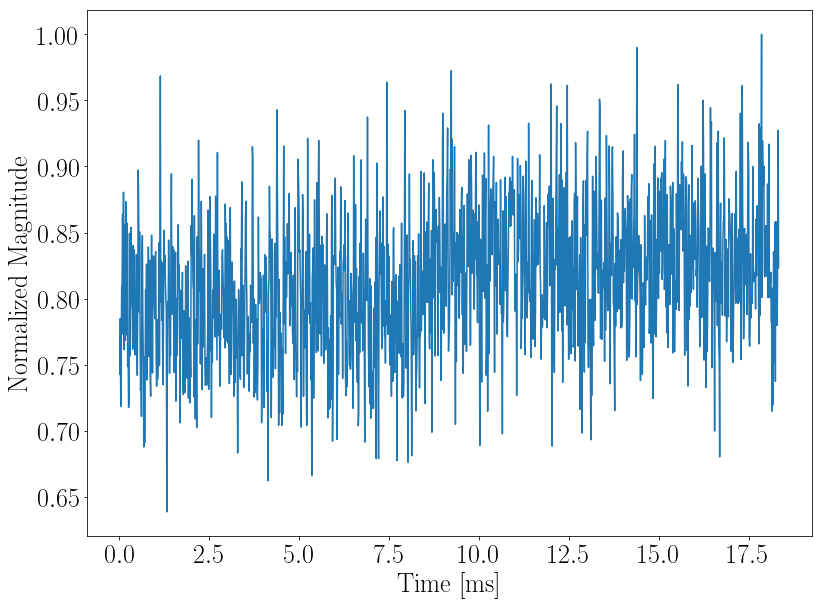

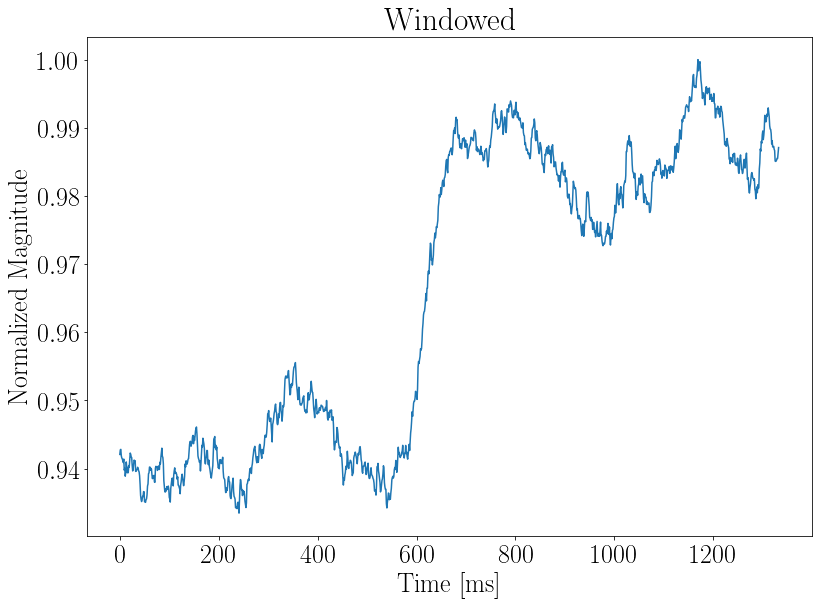

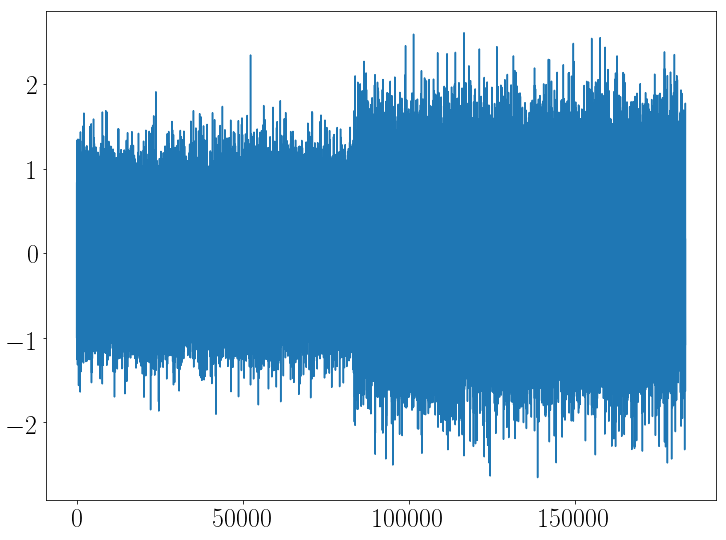

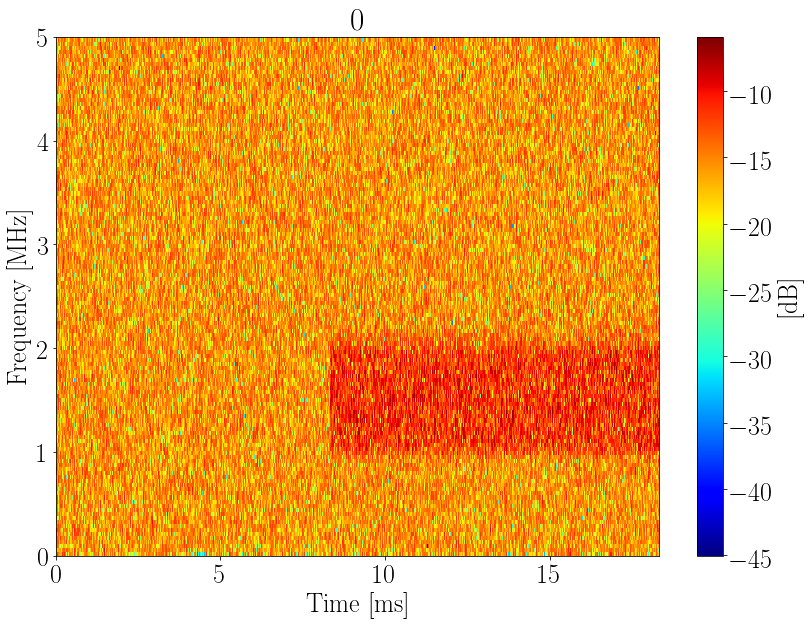

Epoch 10 reached after 0.022 seconds, error: 45.053878
Epoch 20 reached after 0.039 seconds, error: 45.053878


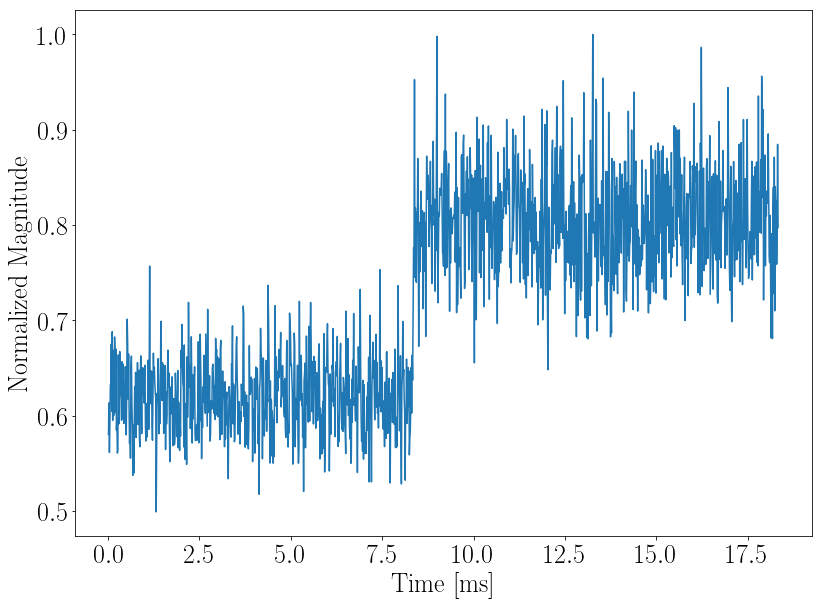

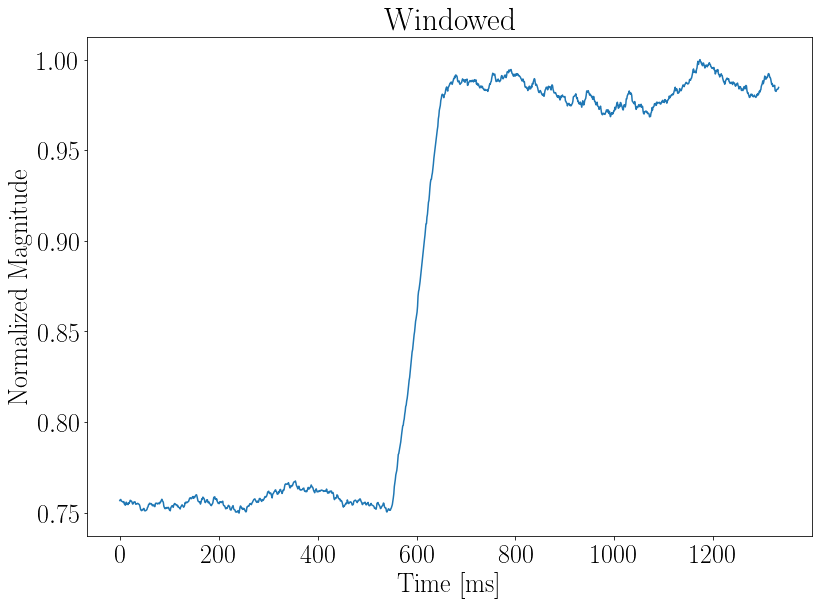

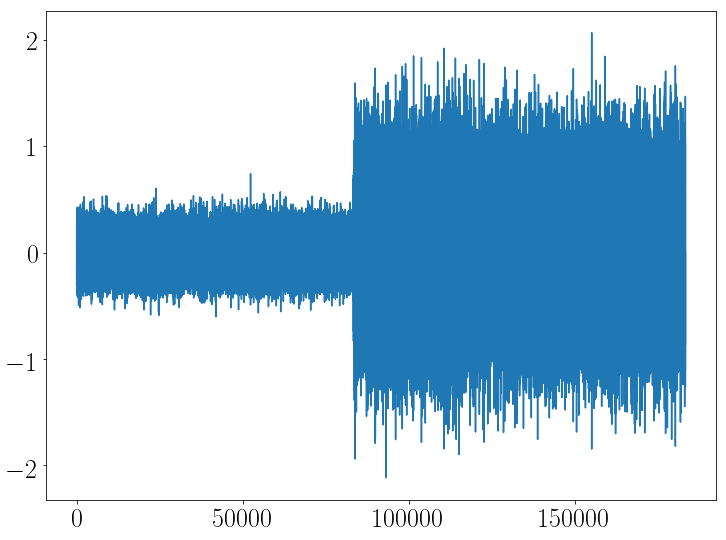

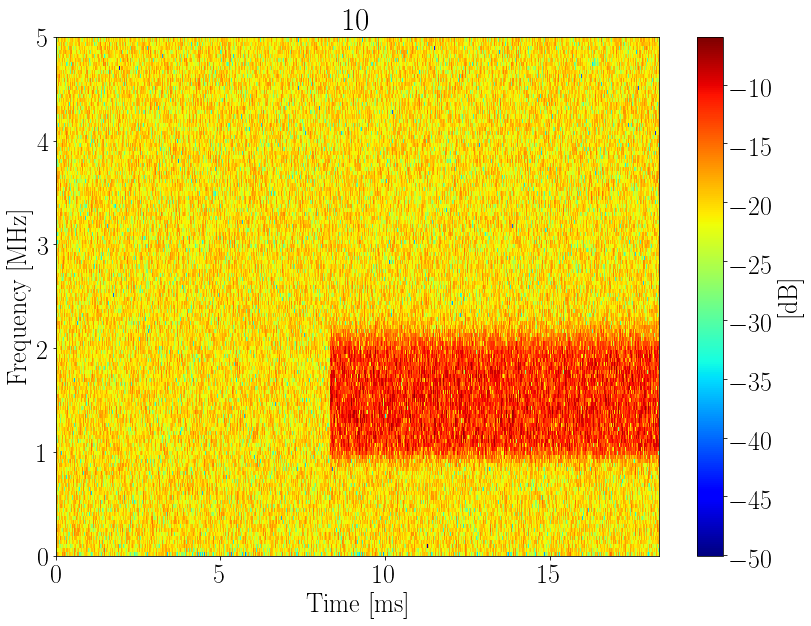

Epoch 10 reached after 0.022 seconds, error: 35.722928
Epoch 20 reached after 0.045 seconds, error: 35.722928


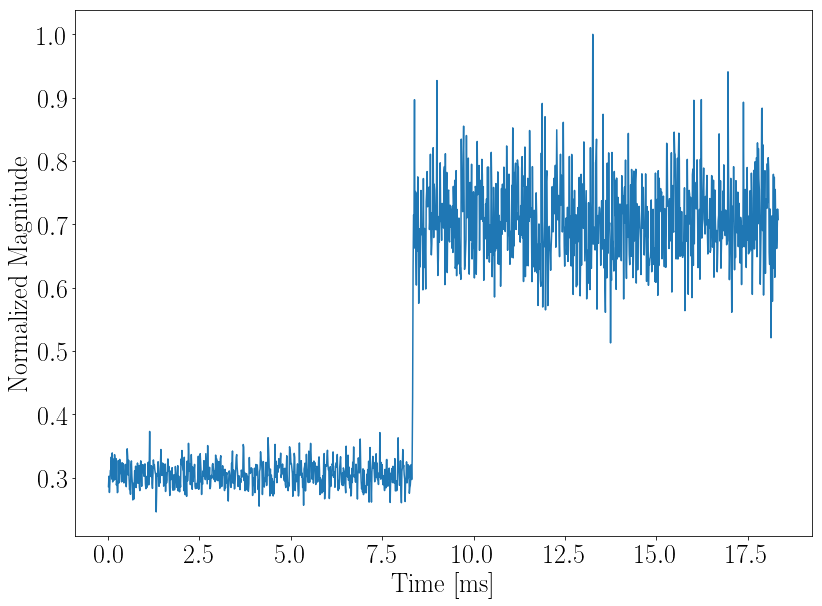

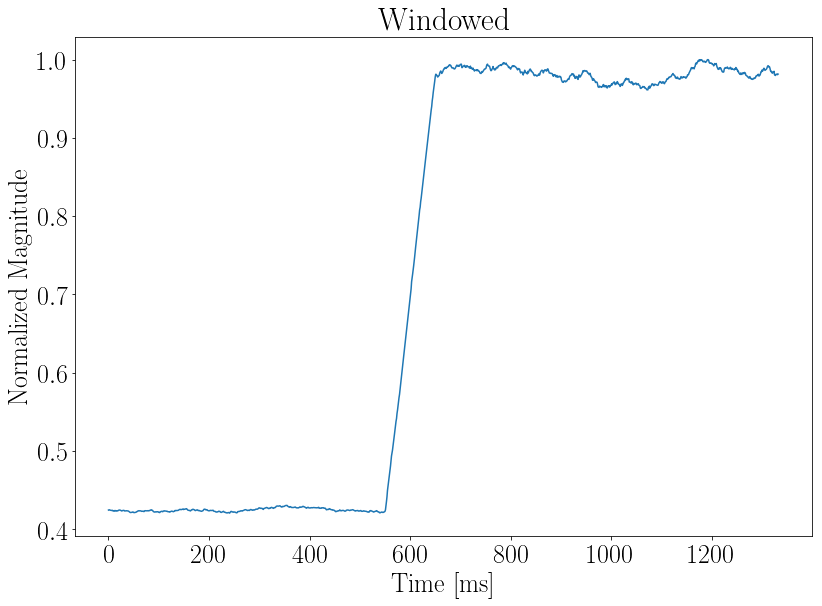

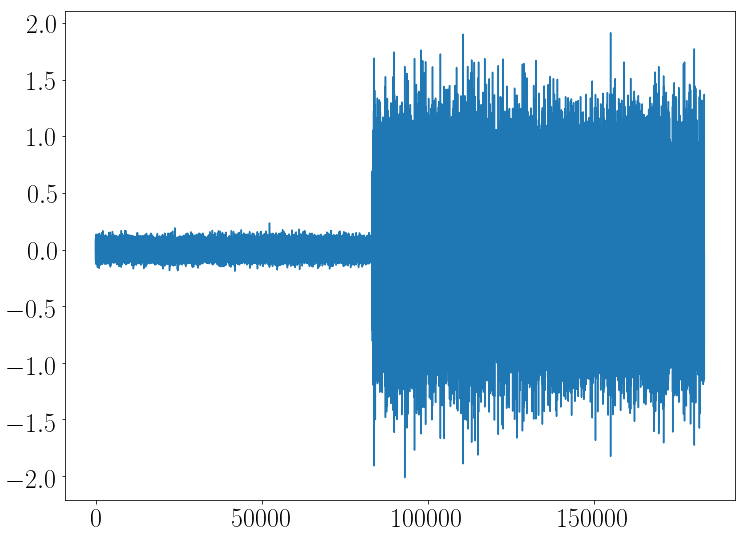

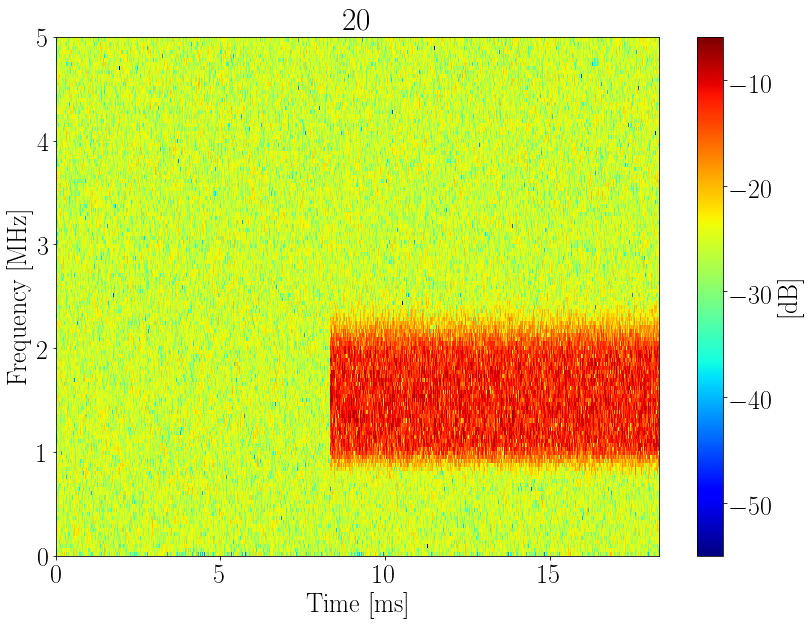

Epoch 10 reached after 0.020 seconds, error: 30.421773
Epoch 20 reached after 0.040 seconds, error: 30.421773


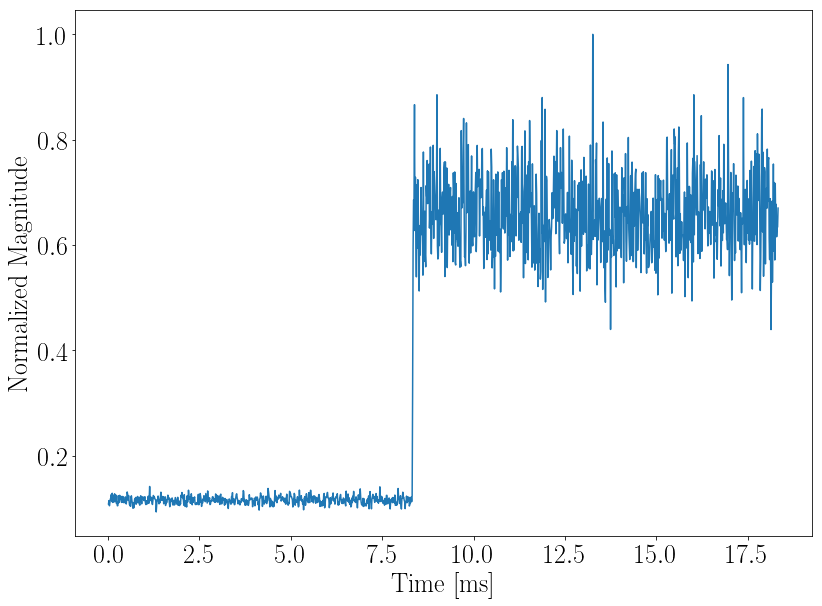

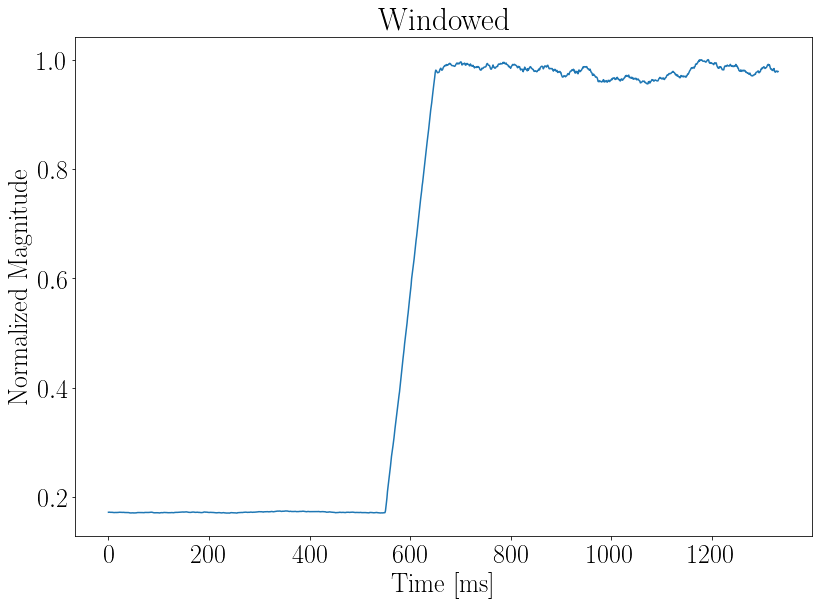

In [17]:
JNRVector = [-20, -10, 0, 10, 20]

JNR = []
[JNR.append(db2pow(i)) for i in JNRVector]

t = np.linspace(0, secondsOfData, numberOfSamples)
signal1 = np.random.randn(numberOfSamples)
lowcut = 1e6
highcut = 2e6
signal1 = butter_bandpass_filter(signal1, lowcut, highcut, fs, order=6)
pow1 = pow_eval(signal1)
signal1 = np.concatenate((np.zeros(np.round(signal1.shape[0]/1.2).astype(int)), signal1))
noise = np.random.randn(len(signal1))
powNoise = pow_eval(noise)

window_length = 100
for j, i in enumerate(JNR):
    powAux = pow1/i
    noise2 = noise*np.sqrt(powAux/powNoise)
    data = signal1+noise2

    plt.figure()
    plt.plot(data)
    plt.show()
    f, t, Zxx = stft(data, fs=fs, nperseg=nperseg, nfft=nfft, boundary=None)
    inputNMF = np.abs(Zxx)
    inputNMF = np.where(inputNMF==0, 1e-12, inputNMF)

    specdB = 10*np.log10(inputNMF)    
    cmap = plt.get_cmap('jet')
    vmin = np.min(specdB)
    vmax = np.max(specdB)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    v = ax.pcolormesh(t*1e3, f/1e6, specdB, vmin=vmin, vmax=vmax, cmap=cmap)
    ax.set_ylabel('Frequency [MHz]')
    ax.set_xlabel('Time [ms]')
    fig.colorbar(v).ax.set_ylabel('[dB]')
    plt.tight_layout()
    saveFig(fig, figPath, ''.join(['spec_input_', exp_name]), save_fig=save_fig)
    plt.title(str(JNRVector[j]))
    plt.show()

    model = NMF(init='nndsvda', max_iter=10000, verbose=2, random_state=1, tol=1e-16, 
                  beta_loss=beta_loss, n_components=1, solver='mu')
    W = model.fit_transform(inputNMF)
    H = model.components_

    for i in range(H.shape[0]):
        HNorm = H[i,:]/np.max(H[i,:])
        H2 = mean_window(HNorm, window_length)
        fig = plt.figure()
        ax = fig.add_subplot(111)
        ax.plot(t*1e3, HNorm)
        ax.set_xlabel('Time [ms]')
        ax.set_ylabel('Normalized Magnitude')
        fig.tight_layout()
        saveFig(fig, figPath, ''.join(['act_', exp_name, beta_loss, str(i)]), save_fig=save_fig)
        plt.show()
        
        fig = plt.figure()
        ax = fig.add_subplot(111)
        ax.plot(H2/np.max(H2))
        ax.set_title('Windowed')
        ax.set_xlabel('Time [ms]')
        ax.set_ylabel('Normalized Magnitude')
        fig.tight_layout()
        saveFig(fig, figPath, ''.join(['act_', exp_name, beta_loss, str(i)]), save_fig=save_fig)
        plt.show()

# Saving log file

In [ ]:
import json

In [ ]:
log_path = './log/'
if not os.path.exists(log_path):
    os.makedirs(log_path)
params = model.get_params()
params['nfft'] = nfft
params['nperseg'] = nperseg
params = json.dumps(params)
if save_fig:
    with open(''.join([log_path, exp_name, beta_loss, '.p']), 'w') as file:
         file.write(params)